In [1]:
from MMT_reduce_module import *

In [2]:
from __future__ import print_function
import numpy as np
import scipy as sp
import scipy.ndimage
from astropy.io import fits
import sys
import numpy.ma as ma
import math
import pidly
import os
import glob
import time
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.visualization import ZScaleInterval
interval = ZScaleInterval()

## MMT_reduce_module Testing

#### The purpose of this notebook is to test functions in the MMT module one-by-one and examine the outputs at each step.

Major to-do items (April 4, 2019): 

* Fix saturated data!
    * Examine how sky frames are being made 
    * Examine how sky subtraction is being performed on science data
    * Determine best practice of aligning saturated frames
    * plt.imshow reduced steps
    * Stacking size issue 
    
* Determine how flatfield generation is being done and improve if need be
    * Debug negative dark frames/negative flat frame issues? -- **done, 5/23**
    * Double-check dome flat correction, now that twilight flat correction is working (with correct inputs)
    
More to-do items (last updated 7/1):
* Ensure corquad correction is applied prior to analysis steps - **done, 5/23**
* Define location for reduced data to be written -- **done, 7/1**
* Check to ensure all flatfields are taken in the same filter - update within module -- **done, 7/1**
* Rotation angle correction and image flip for MMT data (appears to be same VLT conventions) - update within module
* Cross-check sky subtraction in case of very saturated data, and if small changes in rotation angle make difference

### Set up paths to raw data and definitions

In [19]:
path_to_raw_sci = '/Volumes/Passport4TB/MinMs_Data_Testing/HIP12097_MMT_20161012/30.0/'
path_to_raw_darks = '/Volumes/Passport4TB/MinMs_Data_Testing/20161012_Calibrations/darks/'
path_to_raw_flats = '/Volumes/Passport4TB/MinMs_Data_Testing/20161012_Calibrations/twilight/'
objname = 'HIP12097_30s'
flattype = 0 # 0 for sky, 1 for lamp
saturated = 1 # 0 if unsaturated, 1 if saturated
alignflag = 0 # 0 if single star or faint companion, 1 if equal brightness binary or difficult to align for some reason
imsize = 1024

## The following cells are each of the steps of the reduce_raw_sci function

In [20]:
# Make list of science frames and check exposure time 
scilist = glob.glob(path_to_raw_sci + 'q*.fits')

print(f"Number of science frames found: {len(scilist)} \n")


Number of science frames found: 23 



In [21]:
scitimes = [fits.getheader(im, ignore_missing_end = True)['EXPTIME'] for im in scilist]

# check if all of the exposure times in the current directory are the same:
if all(x == scitimes[0] for x in scitimes):
    print("Science frame exposure time: " + str(scitimes[0]) + "\n")
else:
    raise Exception("Exposure times for given list of files do not match. \
    You may need to make/define separate subfolders for different exptimes.")

sci_exptime = scitimes[0]

n = len(scilist)


# get header from science frames to work with
sciheader = fits.getheader(scilist[0])


Science frame exposure time: 30.0



In [22]:
# check for datacubes
if len(fits.getdata(scilist[0]).shape) == 3: # check for data cubes of science frames
    sciarray = np.zeros([imsize,imsize,n*fits.getdata(scilist[0]).shape[0]])
else:
    sciarray = np.zeros([imsize,imsize,n])

if len(fits.getdata(scilist[0]).shape) == 3: # check for data cubes of science frames    
    totalframes = n*fits.getdata(scilist[0]).shape[0]
else:
    totalframes = n

In [23]:
# in case data were rotated during observing sequence, set up empty array of rotation angles
angle = np.zeros(totalframes)

im_index = 0

for ii in range(0, n):
    
    im = fits.getdata(scilist[ii], ignore_missing_end=True)
    header = fits.getheader(scilist[ii],ignore_missing_end=True)
    
    if len(im.shape) == 3: # check for data cubes of science frames
        assert not np.any(np.isnan(im))
        for jj in range(0, im.shape[0]):
            sciarray[:,:,im_index] = im[jj,:,:]
            angle[im_index] = (header['PA'] - header['ROT']) * (np.pi/180.0)
            im_index += 1
    else: 
        sciarray[:,:,ii] = im  
        angle[ii] = (header['PA'] - header['ROT']) * (np.pi/180.0)
    header = fits.getheader(scilist[ii], ignore_missing_end=True)





In [24]:
print(angle)
print(im)

[-0.8097801  -0.79223818 -0.78691628 -0.78168544 -0.77638127 -0.74934932
 -0.74371575 -0.72172952 -0.71567543 -0.70941748 -0.7029843  -0.69229816
 -0.6857176  -0.67902415 -0.67209551 -0.66104097 -0.65400968 -0.64674223
 -0.63949708 -0.61916263 -0.61143682 -0.60370276 -0.59585376]
[[   0.      1307.7513  1220.6771  ... 1333.3844  1330.8589  1314.3203 ]
 [ 325.75934 1451.2681  1421.4031  ... 1336.4957  1326.654   1393.9655 ]
 [ 333.6266  1265.9246  1315.5254  ... 1387.3607  1431.5577  1406.3093 ]
 ...
 [ 317.50174 1442.0865  1524.1453  ... 1567.9668  1677.1624  2105.857  ]
 [ 321.8183  1398.6318  1446.0332  ... 1579.5536  1814.9286  2545.2412 ]
 [ 329.59885 1403.5455  1579.2537  ... 1719.2898  2113.485   2637.5386 ]]


Creating and applying master darks and flats...

Found 16 darks with exposure times of 30.0. 



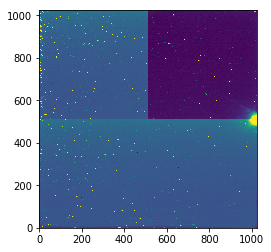

In [25]:
#MASTER_DARK

print("Creating and applying master darks and flats...\n")    

# create master dark matching science exposure times
med_dark = dark_combine(path_to_raw_sci, path_to_raw_darks, sci_exptime, imsize, objname) 

vmin, vmax = interval.get_limits(med_dark)
plt.imshow(med_dark, vmin=vmin, vmax=vmax, origin='lower')

In [26]:
# subtract off the median dark frame from each of the science frames
for ii in range (0, totalframes):
    sciarray[:,:,ii] -= med_dark


In [27]:
flatlist = glob.glob(path_to_raw_flats + '**/q*fits',recursive = True)
flatlist

['/Volumes/Passport4TB/MinMs_Data_Testing/20161012_Calibrations/twilight/bad/qim_2159.fits',
 '/Volumes/Passport4TB/MinMs_Data_Testing/20161012_Calibrations/twilight/bad/qim_2165.fits',
 '/Volumes/Passport4TB/MinMs_Data_Testing/20161012_Calibrations/twilight/bad/qim_2173.fits',
 '/Volumes/Passport4TB/MinMs_Data_Testing/20161012_Calibrations/twilight/bad/qim_2186.fits',
 '/Volumes/Passport4TB/MinMs_Data_Testing/20161012_Calibrations/twilight/sky flat/20.0/qim_2160.fits',
 '/Volumes/Passport4TB/MinMs_Data_Testing/20161012_Calibrations/twilight/sky flat/20.0/qim_2161.fits',
 '/Volumes/Passport4TB/MinMs_Data_Testing/20161012_Calibrations/twilight/sky flat/20.0/qim_2162.fits',
 '/Volumes/Passport4TB/MinMs_Data_Testing/20161012_Calibrations/twilight/sky flat/20.0/qim_2163.fits',
 '/Volumes/Passport4TB/MinMs_Data_Testing/20161012_Calibrations/twilight/sky flat/20.0/qim_2164.fits',
 '/Volumes/Passport4TB/MinMs_Data_Testing/20161012_Calibrations/twilight/sky flat/20.0/qim_2166.fits',
 '/Volumes

Found 55 total flats taken in Ks band filter.

Found 55 twilight flats with exposure times of 20.0. 

Creating new master dark for flats with 20.0s exposure. 

Found 5 darks with exposure times of 20.0. 



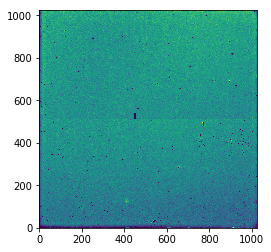

In [28]:
#MEDIAN_AND_MASTER_FLAT

# create the masterflat 
med_flat, master_flat, flatheader = process_flats(path_to_raw_sci, path_to_raw_flats, path_to_raw_darks, imsize, flattype, objname)

vmin, vmax = interval.get_limits(med_flat)
plt.imshow(med_flat, vmin=vmin, vmax=vmax, origin='lower')

In [29]:
# divide each science frame by the masterflat frame
for ii in range(0, totalframes):
    sciarray[:,:,ii] /= master_flat



Creating bad pixel map and correcting for bad pixels and cosmic rays. 
 This may take a moment... 



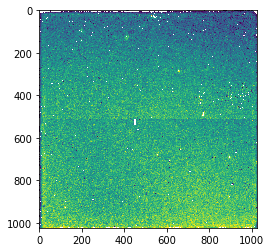

In [30]:
#BAD_PIXEL_MAP

print("Creating bad pixel map and correcting for bad pixels and cosmic rays. \n",
     "This may take a moment... \n") 

# create bad pixel map
badflat = badpixelmap(path_to_raw_sci, med_flat, objname, flatheader)  

vmin, vmax = interval.get_limits(badflat)
plt.imshow(badflat, vmin=vmin, vmax=vmax)

In [31]:
# correct the bad pixels and cosmic rays
reduced_sciarray = correct_bad_pixels(sciarray, badflat)


Correcting image #0
Correcting image #1
Correcting image #2
Correcting image #3
Correcting image #4
Correcting image #5
Correcting image #6
Correcting image #7
Correcting image #8
Correcting image #9
Correcting image #10
Correcting image #11
Correcting image #12
Correcting image #13
Correcting image #14
Correcting image #15
Correcting image #16
Correcting image #17
Correcting image #18
Correcting image #19
Correcting image #20
Correcting image #21
Correcting image #22


In [32]:
pwd

'/Volumes/Passport4TB/FolletteLab/MinMs'

In [33]:
# write out a test reduced science image 
fits.writeto(path_to_raw_sci+'test_reduced_science.fits', reduced_sciarray[:,:,0], overwrite=True)

In [34]:
#MASTER_SKY
print("Creating master sky from science frames...\n") 

# create median sky from stack of science images
sky_output = create_sky_frames(path_to_raw_sci, reduced_sciarray, sciheader, objname, angle)



Creating master sky from science frames...



1599.003858558864


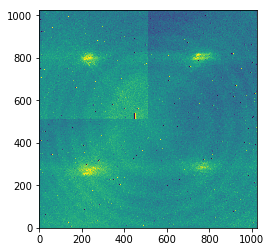

In [35]:
# get median and examine sky output:
print(np.median(sky_output[1]))
vmin, vmax = interval.get_limits(sky_output[1])
plt.imshow(sky_output[1], vmin=vmin, vmax=vmax, origin='lower')

In [36]:
# apply sky subtraction to each science image 
skysub_science_array, rot_flag = sky_subtract(reduced_sciarray, sky_output, angle)

In [37]:
#INDIVIDUAL_REDUCED_SCI_IMAGES
t0=time.time()

# initialize blank list to hold all of the reduced science image names
scinames_list = []


for ii in range(0, totalframes):
    print(f"Saving reduced frame #{ii}")
    sciname = 'reducedsci_00' + str(ii) + '.fits'
    if ii >= 10:
        sciname = 'reducedsci_0' + str(ii) + '.fits'
    if ii >= 100:
        sciname = 'reducedsci_' + str(ii) + '.fits'
    fits.writeto(path_to_raw_sci+sciname, skysub_science_array[:,:,ii], sciheader, overwrite = True, output_verify='silentfix')
    scinames_list.append(sciname)
    
t1=time.time()
print("Time taken: ", (t1-t0)/60.)

Saving reduced frame #0
Saving reduced frame #1
Saving reduced frame #2
Saving reduced frame #3
Saving reduced frame #4
Saving reduced frame #5
Saving reduced frame #6
Saving reduced frame #7
Saving reduced frame #8
Saving reduced frame #9
Saving reduced frame #10
Saving reduced frame #11
Saving reduced frame #12
Saving reduced frame #13
Saving reduced frame #14
Saving reduced frame #15
Saving reduced frame #16
Saving reduced frame #17
Saving reduced frame #18
Saving reduced frame #19
Saving reduced frame #20
Saving reduced frame #21
Saving reduced frame #22
Time taken:  0.03760833342870076


In [38]:
# get current directory where reduced frames are written
current_dir = path_to_raw_sci

# measure star positions in all of the images
xcen, ycen = measure_star_centers(path_to_raw_sci, skysub_science_array, scinames_list, sciheader, saturated, 0, current_dir, saveframes = True)


Moving IDL session to /Volumes/Passport4TB/MinMs_Data_Testing/HIP12097_MMT_20161012/30.0/
% Compiled module: MRDFITS.
% Compiled module: FXPOSIT.
% Compiled module: MRD_HREAD.
% Compiled module: FXPAR.
% Compiled module: GETTOK.
% Compiled module: VALID_NUM.
% Compiled module: MRD_SKIP.
% Compiled module: ARRAY_INDICES.
% Compiled module: MPFIT2DPEAK.
% Compiled module: MPFIT.
% Compiled module: MPFIT2DFUN.
Overwriting existing science frames with star position values: reducedsci_000.fits
Overwriting existing science frames with star position values: reducedsci_001.fits
Overwriting existing science frames with star position values: reducedsci_002.fits
Overwriting existing science frames with star position values: reducedsci_003.fits
Overwriting existing science frames with star position values: reducedsci_004.fits
Overwriting existing science frames with star position values: reducedsci_005.fits
Overwriting existing science frames with star position values: reducedsci_006.fits
Overwrit

In [39]:
print('xcen:', xcen, 'ycen:', ycen)

xcen: [226.80913351 229.79714804 232.5568159  214.43758841 224.84946292
 413.06097988 894.13413588 271.01687048 251.41237606 238.67857752
 258.77703941 721.11061208 717.51329128 706.49413827 711.99216622
 704.92806617 693.92759523 692.9416485  694.44840036 486.31287918
 461.56326062 453.23211601 478.92841418] ycen: [303.88357598 311.05314357 322.80871267 303.3416669  288.49554086
 118.93896044 633.84401628 799.9878342  811.75351731 802.39058779
 780.66637783 764.74156301 769.08190554 766.59549751 750.06268971
 276.64676481 306.97291951 272.55066206 264.95622592 531.29268482
 550.80061975 527.59839387 511.64190419]


In [40]:
#SHIFTED_IMAGES
#STACKED
#FINAL
t0=time.time()
# final step (!) - shift and combine all of the images.
rotate_shift_align(path_to_raw_sci, xcen, ycen, angle, skysub_science_array, objname, sciheader, current_dir, imsize=1024)

t1 = time.time()
timetaken = (t1-t0)/60.
print(f"Completed reduction of {totalframes} images in {timetaken} minutes.")

2173 2144
Shifting image 0 of 23...
Shifting image 1 of 23...
Shifting image 2 of 23...
Shifting image 3 of 23...
Shifting image 4 of 23...
Shifting image 5 of 23...
Shifting image 6 of 23...
Shifting image 7 of 23...
Shifting image 8 of 23...
Shifting image 9 of 23...
Shifting image 10 of 23...
Shifting image 11 of 23...
Shifting image 12 of 23...
Shifting image 13 of 23...
Shifting image 14 of 23...
Shifting image 15 of 23...
Shifting image 16 of 23...
Shifting image 17 of 23...
Shifting image 18 of 23...
Shifting image 19 of 23...
Shifting image 20 of 23...
Shifting image 21 of 23...
Shifting image 22 of 23...
% Compiled module: MRDFITS.
% Compiled module: FXPOSIT.
% Compiled module: MRD_HREAD.
% Compiled module: FXPAR.
% Compiled module: GETTOK.
% Compiled module: VALID_NUM.
% Compiled module: MRD_SKIP.
% Compiled module: MWRFITS.
% Compiled module: FXADDPAR.
% Compiled module: SXDELPAR.
Completed reduction of 23 images in 0.6740054726600647 minutes.









## Run all of the above reduction steps in one go:

In [6]:
#Running all the above reduction steps in one go
reduce_raw_sci(path_to_raw_sci, path_to_raw_darks, path_to_raw_flats, objname, flattype, saturated, alignflag, imsize = 1024)

Number of science frames found: 37 

Science frame exposure time: 0.8

Creating and applying master darks and flats...

Found 52 darks with exposure times of 0.8. 

Found 55 total flats taken in Ks band filter.

Found 55 twilight flats with exposure times of 20.0. 

Creating new master dark for flats with 20.0s exposure. 

Found 5 darks with exposure times of 20.0. 

Creating bad pixel map and correcting for bad pixels and cosmic rays. 
 This may take a moment... 

Correcting image #0
Correcting image #1
Correcting image #2
Correcting image #3
Correcting image #4
Correcting image #5
Correcting image #6
Correcting image #7
Correcting image #8
Correcting image #9
Correcting image #10
Correcting image #11
Correcting image #12
Correcting image #13
Correcting image #14
Correcting image #15
Correcting image #16
Correcting image #17
Correcting image #18
Correcting image #19
Correcting image #20
Correcting image #21
Correcting image #22
Correcting image #23
Correcting image #24
Correcting imag